
# Análise de Sentimentos em Reviews da Amazon

Este script processa reviews de produtos da Amazon, realiza análise de sentimentos
usando diferentes abordagens (SVM com Bag of Words, SVM com Embeddings e BERT)
e apresenta os resultados em gráficos e métricas.


In [ ]:
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from wordcloud import WordCloud
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay
import tensorflow as tf
from google.colab import drive
import shutil

# Configurações gerais para salvar checkpoints
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, 'best_model')

# 1. Carregamento e Pré-processamento dos Dados

Esta seção carrega os dados de reviews, realiza pré-processamento
para limpar os textos e os organiza em rótulos de sentimento.


In [ ]:
import string
from nltk.corpus import stopwords
import nltk
# Carregar dados do CSV
url = "https://raw.githubusercontent.com/pscoutosoares/nlp-amazon/refs/heads/main/amazon_reviews.csv"
data = pd.read_csv(url)
data = data[['overall', 'reviewText']]
nltk.download("stopwords")


# Função para pré-processar o texto
def preprocess_text(text):
    """Limpa o texto removendo pontuações, stopwords e transformando para minúsculas."""
    stop_words = stopwords.words("english")

    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

# Aplicar o pré-processamento nos textos
data["clean_review"] = data["reviewText"].apply(preprocess_text)

# Mapear notas em rótulos de sentimento
def map_to_sentiment(score):
    """Converte notas em rótulos de sentimento."""
    if score >= 4:
        return "positive"
    elif score <= 2:
        return "negative"
    else:
        return "neutral"

data["sentiment"] = data["overall"].apply(map_to_sentiment)

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    data["clean_review"], data["overall"], test_size=0.2, random_state=42
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Análise Exploratória e Visualização

Aqui são geradas visualizações como nuvem de palavras
e gráficos para entender os dados e sua distribuição.

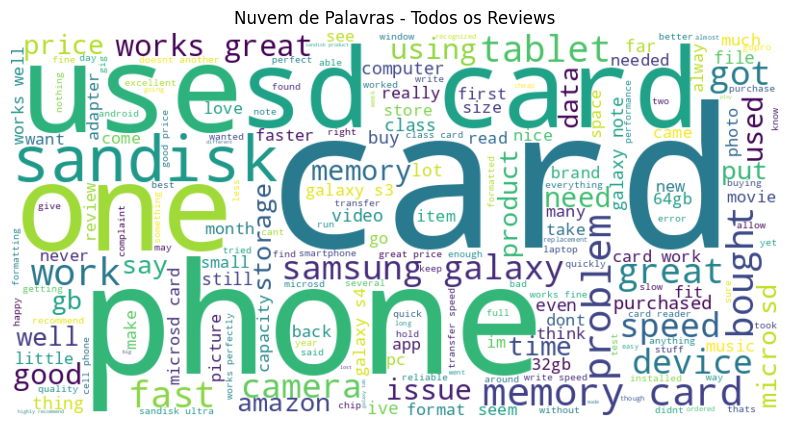

In [ ]:
# Nuvem de Palavras - Frequência geral
all_text = " ".join(data["clean_review"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de Palavras - Todos os Reviews")
plt.show()

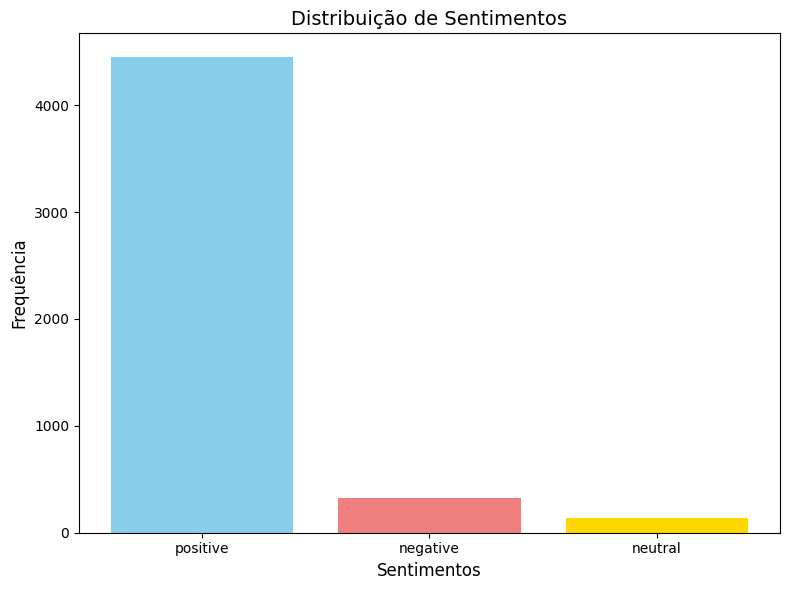

In [ ]:
# Distribuição de Sentimentos
sentiment_counts = data['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['skyblue', 'lightcoral', 'gold'])
plt.title("Distribuição de Sentimentos", fontsize=14)
plt.xlabel("Sentimentos", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


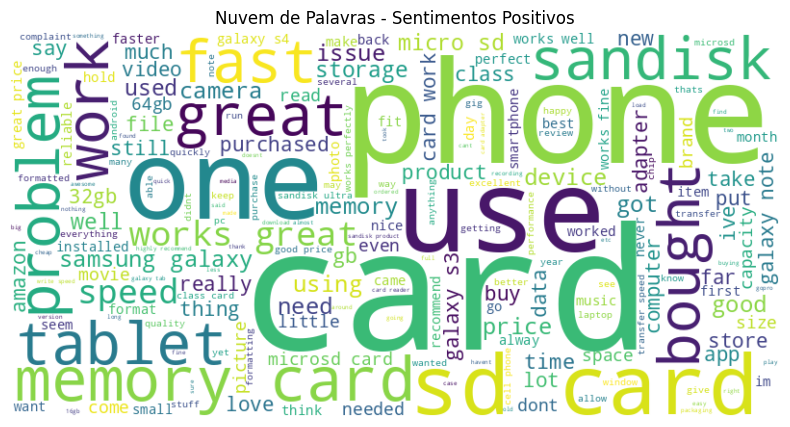

In [ ]:
# Nuvem de Palavras - Sentimentos Positivos
positive_text = " ".join(data[data['sentiment'] == 'positive']['clean_review'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de Palavras - Sentimentos Positivos")
plt.show()

<ipython-input-8-4def8e7abf54>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='word_count', data=data, palette='Set2')


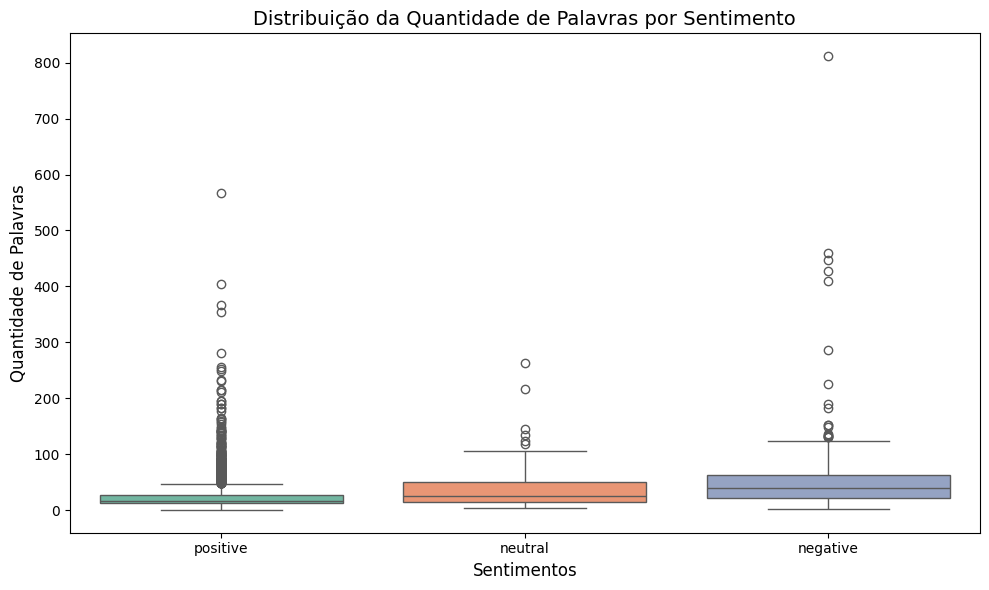

In [ ]:
# Boxplot da quantidade de palavras por sentimento
data['word_count'] = data['clean_review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='word_count', data=data, palette='Set2')
plt.title("Distribuição da Quantidade de Palavras por Sentimento", fontsize=14)
plt.xlabel("Sentimentos", fontsize=12)
plt.ylabel("Quantidade de Palavras", fontsize=12)
plt.tight_layout()
plt.show()

# 3. Modelagem com Diferentes Abordagens

Testamos diferentes abordagens para análise de sentimentos:
1. SVM com Bag of Words
2. SVM com Embeddings (spaCy)
3. Fine-tuning com BERT

In [ ]:
# Plot para matriz de confusão
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## SVM com Bag of Words

In [ ]:
pipeline_tfidf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("classifier", SVC())
])

param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf"]
}

# Realizar busca de parâmetros
grid_search = GridSearchCV(pipeline_tfidf, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Melhor modelo com Bag of Words
y_pred_bow = grid_search.best_estimator_.predict(X_test)
accuracy_bow = accuracy_score(y_test, y_pred_bow)
f1_bow = f1_score(y_test, y_pred_bow, average='weighted')


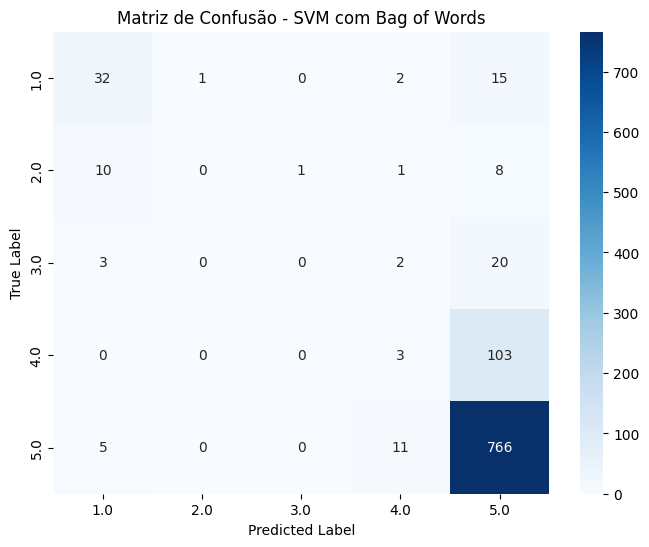

In [ ]:
# Predição com o modelo otimizado
y_pred_bow = grid_search.best_estimator_.predict(X_test)

# Matriz de confusão para SVM com Bag of Words
plot_confusion_matrix(y_test, y_pred_bow, title="Matriz de Confusão - SVM com Bag of Words")

## SVM com Embeddings (spaCy)

In [ ]:
import spacy
from sklearn.preprocessing import StandardScaler

# Carregar modelo spaCy
nlp = spacy.load("en_core_web_sm")

X_train = X_train[X_train != ""]
y_train = y_train[X_train.index]
X_test = X_test[X_test != ""]
y_test = y_test[X_test.index]

# Converter textos para embeddings
X_train_embedded = np.array([nlp(text).vector for text in X_train])
X_test_embedded = np.array([nlp(text).vector for text in X_test])

# Normalizar embeddings
scaler = StandardScaler()
X_train_embedded = scaler.fit_transform(X_train_embedded)
X_test_embedded = scaler.transform(X_test_embedded)

# Treinar SVM com embeddings
svm_embedding = SVC()
svm_embedding.fit(X_train_embedded, y_train)
y_pred_embed = svm_embedding.predict(X_test_embedded)

# Avaliar modelo
accuracy_embed = accuracy_score(y_test, y_pred_embed)
f1_embed = f1_score(y_test, y_pred_embed, average='weighted')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


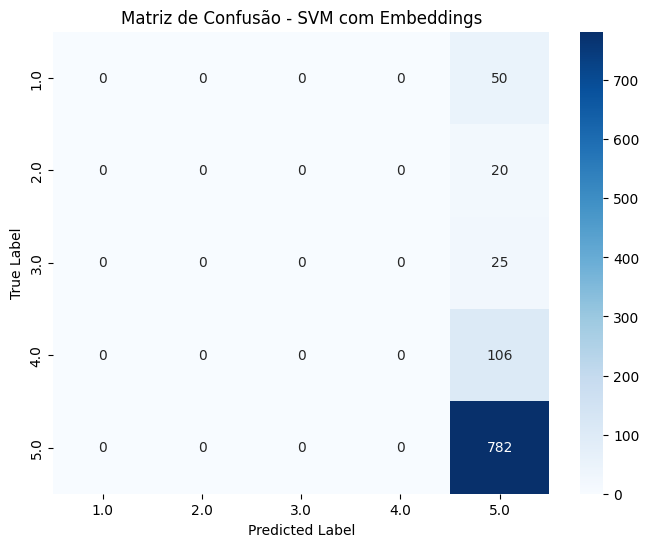

In [ ]:
# Predição com SVM e Embeddings
y_pred_embed = svm_embedding.predict(X_test_embedded)

# Matriz de confusão para SVM com Embeddings
plot_confusion_matrix(y_test, y_pred_embed, title="Matriz de Confusão - SVM com Embeddings")

## Modelagem com BERT

Utilizar a pasta publica `checkpoints` como referencia para o melhor checkpoint

https://drive.google.com/drive/folders/1--dYYdwklibiQQLQQWpzJ4vv36jPf5nu?usp=sharing

In [ ]:
def load_checkpoint_from_drive():
    """Carrega o checkpoint salvo no Google Drive."""
    drive.mount('/content/drive')
    drive_checkpoint_path = '/content/drive/My Drive/Colab Notebooks/checkpoints'
    if os.path.exists(drive_checkpoint_path):
        shutil.copytree(drive_checkpoint_path, checkpoint_dir, dirs_exist_ok=True)
        print("Checkpoints carregados do Google Drive.")
    else:
        print("Nenhum checkpoint encontrado no Google Drive.")

# Carregar checkpoints do Google Drive
load_checkpoint_from_drive()

# Preparar tokenizador e modelo
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoints carregados do Google Drive.


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenizar dados
X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="tf")
X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="tf")

# Carregar pesos se disponíveis
if os.path.exists(checkpoint_filepath + ".index"):
    model.load_weights(checkpoint_filepath)
    print("Pesos carregados do checkpoint.")
else:
    print("Nenhum checkpoint disponível. O treinamento começará do zero.")

    # Compilar modelo
    optimizer = AdamWeightDecay(learning_rate=3e-5)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    # Treinar modelo
    history = model.fit(
        X_train_tokens.data,
        y_train - 1,
        validation_data=(X_test_tokens.data, y_test),
        epochs=5,
        batch_size=6
    )

# Prever e avaliar
predictions = model.predict(X_test_tokens.data).logits
y_pred_bert = np.argmax(predictions, axis=1)
accuracy_bert = accuracy_score(y_test, y_pred_bert)
f1_bert = f1_score(y_test, y_pred_bert, average="weighted")

Pesos carregados do checkpoint.
31/31 [==============================] - 37s 1s/step


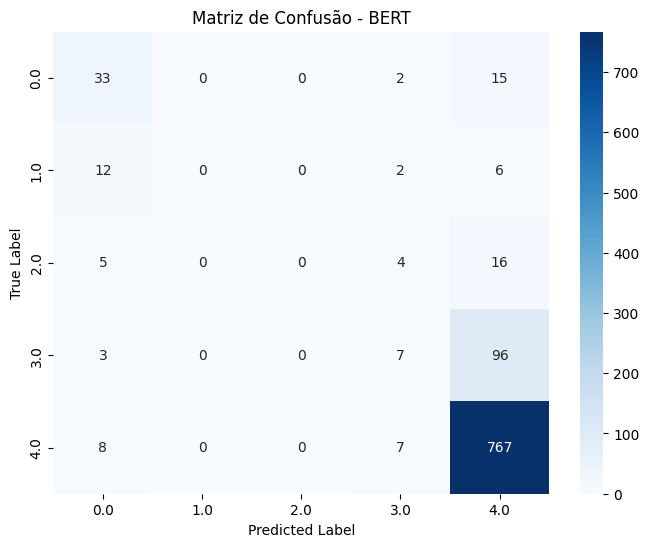

In [ ]:
# Predição com BERT
y_pred_bert = np.argmax(predictions, axis=1)

# Matriz de confusão para BERT
plot_confusion_matrix(y_test - 1, y_pred_bert, title="Matriz de Confusão - BERT")

# 4. Visualização dos Resultados

Comparação entre os modelos com gráficos de barras mostrando
as métricas de desempenho (Acurácia e F1-Score).

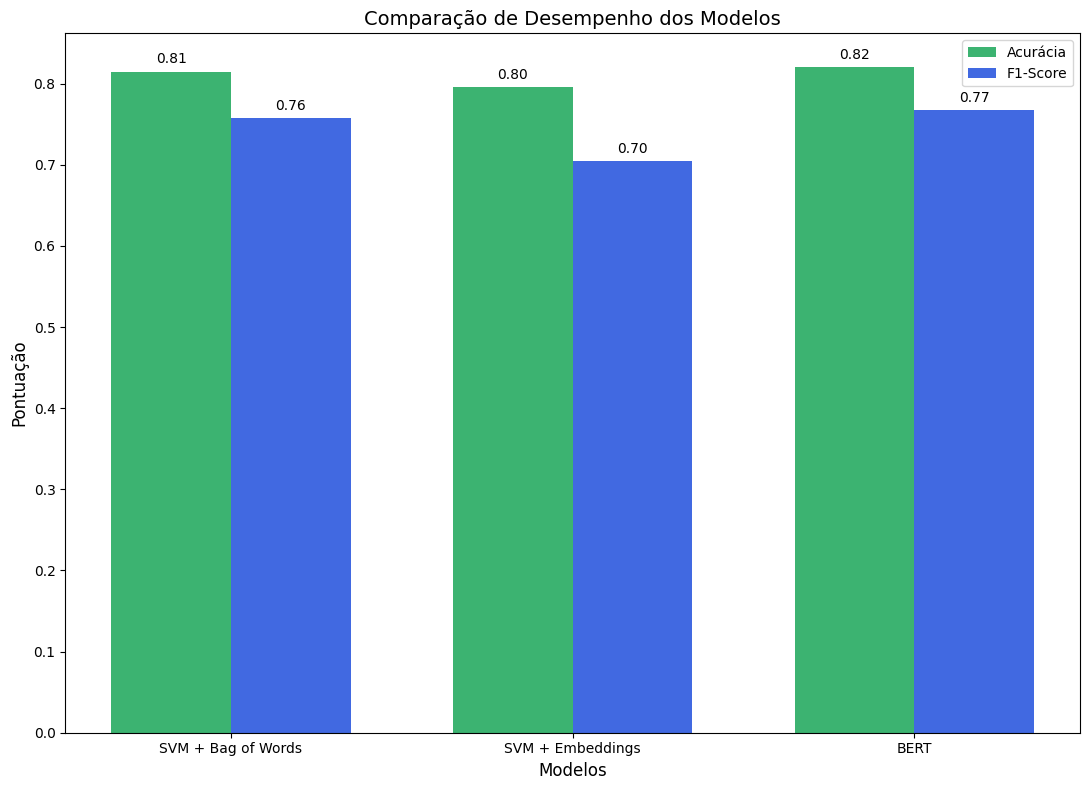

In [ ]:
# Comparação de desempenho
results = {
    "Modelo": ["SVM + Bag of Words", "SVM + Embeddings", "BERT"],
    "Acurácia": [accuracy_bow, accuracy_embed, accuracy_bert],
    "F1-Score": [f1_bow, f1_embed, f1_bert]
}
results_df = pd.DataFrame(results)

# Plotar resultados
x = np.arange(len(results_df['Modelo']))
width = 0.35

plt.figure(figsize=(11, 8))
plt.bar(x - width/2, results_df['Acurácia'], width, label='Acurácia', color='mediumseagreen')
plt.bar(x + width/2, results_df['F1-Score'], width, label='F1-Score', color='royalblue')
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("Pontuação", fontsize=12)
plt.title("Comparação de Desempenho dos Modelos", fontsize=14)
plt.xticks(x, results_df['Modelo'], fontsize=10)
plt.legend()

# Adicionar valores no topo das barras
for i, v in enumerate(results_df['Acurácia']):
    plt.text(i - width/2, v + 0.01, f'{v:.2f}', ha='center', fontsize=10)
for i, v in enumerate(results_df['F1-Score']):
    plt.text(i + width/2, v + 0.01, f'{v:.2f}', ha='center', fontsize=10)


plt.tight_layout()
plt.show()
